# Multi‑Source Health Evidence Extractor — Improved Notebook

This notebook assembles women’s‑health evidence for downstream LLM use. It supports **two modes**:
1) **Simulation mode** — synthetic PubMed‑like and patient forum data (fast, offline).
2) **Real mode** — actual **PubMed** retrieval via **NCBI Entrez** (Biopython).

The pipeline outputs a unified, **LLM‑ready JSON** payload aggregating PubMed articles, patient experiences, and educational resources.

##  Quick Start

**Choose a mode** and run the corresponding section below:

- **Simulation mode (offline)**  
  1. Run the cell: **Install / Imports (optional)**  
  2. Run: **Synthetic Data Fetch** → **Extraction & Analysis** → **Package for LLM** → **Export JSON**

- **Real PubMed mode (online)**  
  1. Run the cell: **Entrez Setup (REQUIRED)** — set your real email (and API key if available)  
  2. Run: **Fetch PubMed via Entrez** → **Extraction & Analysis** → **Package for LLM** → **Export JSON**

> The notebook keeps the **latest definition** of a function in memory. If you run both synthetic and Entrez versions of `fetch_pubmed_data`, the most recent cell you executed will be used.

##  Environment & Dependencies

This notebook expects Python 3.9+ and the following packages:

- core: `pandas`, `numpy`, `requests`
- PubMed API: `biopython` (for `Bio.Entrez`)
- synthetic data: `faker`
- optional viz: `matplotlib`, `seaborn`

You can install them inside the notebook with the next cell.

In [ ]:
# (Optional) Install dependencies inside the notebook kernel
# Note: Comment out lines you don't need.
# %pip install -U pandas numpy requests biopython faker matplotlib seaborn ipykernel

##  Entrez Setup (REQUIRED for Real PubMed Mode)

NCBI requires a **valid email**. An API key increases rate limits. Respect NCBI fair‑use policies.

In [ ]:
# --- Entrez Setup (execute before "Fetch PubMed via Entrez") ---
try:
    from Bio import Entrez
    Entrez.email = "your_email@domain.com"   # <-- set a real email
    # Entrez.api_key = "YOUR_NCBI_API_KEY"   # optional, improves rate limits
    print("Entrez configured.")
except Exception as e:
    print("Biopython not installed or import failed. Install with: %pip install biopython")
    raise

##  Local Caching (Optional, speeds up iteration)

Use a tiny disk cache to avoid repeated API calls during prototyping. This is a simple JSON‑on‑disk pattern; swap for `joblib.Memory` or `sqlite` as needed.

In [ ]:
import json, hashlib
from pathlib import Path
from datetime import datetime

_CACHE_DIR = Path("./.cache_pubmed")
_CACHE_DIR.mkdir(exist_ok=True)

def _cache_key(prefix: str, payload: dict) -> Path:
    m = hashlib.sha256(json.dumps(payload, sort_keys=True).encode("utf-8")).hexdigest()
    return _CACHE_DIR / f"{prefix}_{m}.json"

def cache_get(prefix: str, payload: dict):
    path = _cache_key(prefix, payload)
    if path.exists():
        try:
            return json.loads(path.read_text(encoding="utf-8"))
        except Exception:
            return None
    return None

def cache_set(prefix: str, payload: dict, data: dict):
    path = _cache_key(prefix, payload)
    path.write_text(json.dumps({"cached_at": datetime.utcnow().isoformat() + "Z", "data": data}, ensure_ascii=False, indent=2), encoding="utf-8")
    return path

##  Fetch PubMed via Entrez (Real Mode)

Example query; tune with MeSH terms, date filters, etc.

In [ ]:
# Example: Real PubMed fetch (Entrez) with simple cache
from typing import List, Dict

def fetch_pubmed_data_entrez(query: str, max_records: int = 10) -> List[Dict]:
    # try cache first
    cached = cache_get("entrez", {"q": query, "max": max_records})
    if cached:
        print("Loaded from cache.")
        return cached["data"]
    # live fetch
    from Bio import Entrez
    search = Entrez.esearch(db="pubmed", term=query, retmax=max_records)
    record = Entrez.read(search)
    ids = record.get("IdList", [])
    results = []
    if ids:
        handle = Entrez.efetch(db="pubmed", id=",".join(ids), rettype="medline", retmode="text")
        text = handle.read()
        # Very lightweight parse: store raw entry blocks (for demo).
        # In practice, use Medline parser or ESummary/EFetch XML.
        for i, chunk in enumerate(text.split("\n\n")):
            if chunk.strip():
                results.append({
                    "pubmed_id": ids[i % len(ids)] if ids else None,
                    "title": chunk.splitlines()[0][:300] if chunk else "N/A",
                    "abstract": "N/A",  # replace with a proper MEDLINE/ESummary parse
                    "raw": chunk,
                })
    cache_set("entrez", {"q": query, "max": max_records}, results)
    return results

# Demo call (uncomment when Entrez is configured)
# pubmed_real = fetch_pubmed_data_entrez("women's health", max_records=5)
# len(pubmed_real), pubmed_real[:1]

##  Synthetic Data (Offline Mode)

Fast prototyping without internet. Produces PubMed‑like and forum‑like entries.

In [ ]:
import random, uuid
import numpy as np
import pandas as pd
from faker import Faker

fake = Faker()
Faker.seed(42)
np.random.seed(42)
random.seed(42)

def fetch_pubmed_data_synth(query: str, max_records: int = 5):
    rows = []
    for i in range(max_records):
        rows.append({
            "pubmed_id": str(uuid.uuid4())[:8],
            "title": f"Synth study on {query}: {fake.sentence(nb_words=6)}",
            "abstract": fake.paragraph(nb_sentences=3),
        })
    return rows

def fetch_patient_experience_synth(topic: str, max_records: int = 5):
    rows = []
    for i in range(max_records):
        rows.append({
            "post_id": str(uuid.uuid4())[:8],
            "user": fake.user_name(),
            "content": f"{topic}: " + fake.paragraph(nb_sentences=2),
            "timestamp": fake.date_time_this_year().isoformat(),
        })
    return rows

# Demo
# pubmed_synth = fetch_pubmed_data_synth("PCOS", 3)
# patient_synth = fetch_patient_experience_synth("PCOS", 3)
# pubmed_synth[:1], patient_synth[:1]

##  Extraction & Analysis

Placeholders shown below — swap in scispaCy or LLMs for real extraction (PICO, demographics, outcomes).

In [ ]:
def extract_study_details(record: dict) -> dict:
    text = record.get("abstract") or record.get("raw") or ""
    return {
        "description": (text or "")[:160],
        "eligibility": None,
        "interventions": None,
        "outcomes": None,
        "results": None,
    }

def full_text_analysis(text: str) -> dict:
    # Placeholder: return first 120 chars and a naive "topics" bag
    snippet = (text or "")[:120]
    topics = [w.strip(".,").lower() for w in snippet.split() if len(w) > 5][:5]
    return {"summary": snippet, "topics": topics}

def track_study_progression(record: dict) -> dict:
    return {"status": "unknown", "as_of": pd.Timestamp.utcnow().isoformat()}

def analyze_study_demographics(record: dict) -> dict:
    # Simulated demo; replace with real trial metadata
    return {"n": int(np.random.randint(30, 300)), "age_mean": round(np.random.normal(38, 6), 1), "female_ratio": round(np.random.uniform(0.5, 0.9), 2)}

##  Package for LLM + 🚀 Export JSON

In [ ]:
from pathlib import Path
import json

def prepare_llm_input(pubmed_rows, patient_rows=None, edu_rows=None) -> dict:
    return {
        "pubmed_data": pubmed_rows or [],
        "patient_experience": patient_rows or [],
        "educational_resources": edu_rows or [],
        "schema_version": "0.1.0",
        "retrieved_at": pd.Timestamp.utcnow().isoformat(),
        "provenance": {"pubmed": "Entrez or synthetic", "patient": "csv or synthetic", "education": "csv optional"},
    }

def export_llm_json(payload: dict, out_path: str | Path = "llm_input.json") -> Path:
    out_path = Path(out_path)
    out_path.write_text(json.dumps(payload, ensure_ascii=False, indent=2), encoding="utf-8")
    print(f"Saved JSON → {out_path.resolve()}")
    return out_path

# Example wiring (uncomment one mode):
# --- Simulation mode ---
# pub = fetch_pubmed_data_synth("PCOS", 5)
# pts = fetch_patient_experience_synth("PCOS", 5)
# payload = prepare_llm_input(pub, pts, edu_rows=None)
# export_llm_json(payload, "llm_input_synth.json")

# --- Real mode ---
# pub = fetch_pubmed_data_entrez("women's health", 5)
# payload = prepare_llm_input(pub, None, None)
# export_llm_json(payload, "llm_input_pubmed.json")

##  Ethics & Compliance

- Do **not** load or export PHI/PII.  
- Respect **NCBI usage** and fair‑use limits.  
- Maintain citations (PMIDs/DOIs) when publishing outputs.

##  Notebook Map (Sections)

1. **Quick Start**  
2. **Environment & Dependencies**  
3. **Entrez Setup (Real Mode)**  
4. **Local Caching (Optional)**  
5. **Fetch PubMed via Entrez (Real Mode)**  
6. **Synthetic Data (Offline Mode)**  
7. **Extraction & Analysis**  
8. **Package for LLM + Export JSON**  
9. **Ethics & Compliance**

In [1]:
# Import libraries for data manipulation, visualization, and API calls.  
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns  
import json  
import os  
import requests  
from datetime import datetime, timedelta  
import random  
import uuid  
from faker import Faker  
  
# Set up visualization and reproducibility options.  
sns.set(style='whitegrid')  
plt.rcParams['figure.figsize'] = (10, 6)  
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', 1000)  
  
# Initialize Faker for synthetic data  
fake = Faker()  
Faker.seed(42)  
np.random.seed(42)  
random.seed(42)  
  
print('Libraries imported and environment setup complete.')  

Libraries imported and environment setup complete.


In [29]:
# In a production system, this could be loaded from a JSON file.  
  
data_schema = {  
    "patient": ["id", "age", "gender", "diagnosis"],  
    "study": ["study_id", "description", "eligibility", "interventions", "outcomes", "results", "status"]  
}  
print("Data schema loaded:", data_schema)  

Data schema loaded: {'patient': ['id', 'age', 'gender', 'diagnosis'], 'study': ['study_id', 'description', 'eligibility', 'interventions', 'outcomes', 'results', 'status']}


In [3]:
# Define a function to simulate fetching PubMed/MEDLINE data.  
def fetch_pubmed_data(query, max_records=5):  
    # In practice, this would use the Entrez API.  
    records = []  
    for i in range(max_records):  
        record = {  
            'pubmed_id': str(uuid.uuid4()),  
            'title': query + " article " + str(i),  
            'abstract': fake.text(max_nb_chars=200)  
        }  
        records.append(record)  
    print("Synthetic PubMed data fetched for query:", query)  
    return records  
  
# Define a function to simulate fetching patient experience data (forums, support groups).  
def fetch_patient_experience_data(topic, max_records=5):  
    records = []  
    for i in range(max_records):  
        record = {  
            'post_id': str(uuid.uuid4()),  
            'user': fake.user_name(),  
            'content': fake.sentence(nb_words=20),  
            'timestamp': datetime.now().isoformat()  
        }  
        records.append(record)  
    print("Synthetic patient experience data fetched for topic:", topic)  
    return records  
  
# Test these functions:  
pubmed_data = fetch_pubmed_data("women health")  
patient_data = fetch_patient_experience_data("women health")  
print("PubMed Data (first record):", pubmed_data[0])  
print("Patient Experience Data (first record):", patient_data[0])  

Synthetic PubMed data fetched for query: women health
Synthetic patient experience data fetched for topic: women health
PubMed Data (first record): {'pubmed_id': '7daa469f-dd73-47eb-9e7d-b7c903d31e79', 'title': 'women health article 0', 'abstract': 'Score each cause. Quality throughout beautiful instead.\nDespite measure ago current.'}
Patient Experience Data (first record): {'post_id': 'e7d19ce3-658a-4d6a-a50f-ca1239270bfe', 'user': 'smoore', 'content': 'Why often my security arm once me system church whether bag control organization push dog build three.', 'timestamp': '2025-03-31T12:12:41.932135'}


In [4]:
# Define a function to simulate fetching PubMed/MEDLINE data.  
def fetch_pubmed_data(query, max_records=5):  
    # In practice, this would use the Entrez API.  
    records = []  
    for i in range(max_records):  
        record = {  
            'pubmed_id': str(uuid.uuid4()),  
            'title': query + " article " + str(i),  
            'abstract': fake.text(max_nb_chars=200)  
        }  
        records.append(record)  
    print("Synthetic PubMed data fetched for query:", query)  
    return records  
  
# Define a function to simulate fetching patient experience data (forums, support groups).  
def fetch_patient_experience_data(topic, max_records=5):  
    records = []  
    for i in range(max_records):  
        record = {  
            'post_id': str(uuid.uuid4()),  
            'user': fake.user_name(),  
            'content': fake.sentence(nb_words=20),  
            'timestamp': datetime.now().isoformat()  
        }  
        records.append(record)  
    print("Synthetic patient experience data fetched for topic:", topic)  
    return records  
  
# Test these functions:  
pubmed_data = fetch_pubmed_data("women health")  
patient_data = fetch_patient_experience_data("women health")  
print("PubMed Data (first record):", pubmed_data[0])  
print("Patient Experience Data (first record):", patient_data[0])  

Synthetic PubMed data fetched for query: women health
Synthetic patient experience data fetched for topic: women health
PubMed Data (first record): {'pubmed_id': '48414974-24b2-4d32-b40c-f24425bcfeb8', 'title': 'women health article 0', 'abstract': 'Wish specific thing agent. Site in prove same easy city.\nThe teach develop staff least figure. Development process huge everything attorney.'}
Patient Experience Data (first record): {'post_id': '8f1929e4-3e10-4c65-9efc-db4c78bb44fd', 'user': 'mdavid', 'content': 'Option store drug recent feeling range south someone not American mouth product attention.', 'timestamp': '2025-03-31T12:12:57.299447'}


In [5]:
# Define function to simulate fetching medical guidelines.  
def fetch_medical_guidelines(specialty):  
    guidelines = {  
        'ACOG': "Guideline for " + specialty + " from ACOG.",  
        'SOGC': "Guideline for " + specialty + " from SOGC.",  
        'WHO': "Guideline for " + specialty + " from WHO."  
    }  
    print("Synthetic medical guidelines fetched for specialty:", specialty)  
    return guidelines  
  
# Define function to simulate fetching educational resources.  
def fetch_educational_resources(topic, max_records=5):  
    resources = []  
    for i in range(max_records):  
        resource = {  
            'title': topic + " education resource " + str(i),  
            'description': fake.text(max_nb_chars=100),  
            'resource_type': random.choice(['video', 'article', 'course']),  
            'url': fake.url()  
        }  
        resources.append(resource)  
    print("Synthetic educational resources fetched for topic:", topic)  
    return resources  
  
# Test the functions:  
guidelines = fetch_medical_guidelines("women health")  
edu_resources = fetch_educational_resources("women health")  
print("Medical Guidelines:", guidelines)  
print("Educational Resources (first record):", edu_resources[0])  

Synthetic medical guidelines fetched for specialty: women health
Synthetic educational resources fetched for topic: women health
Medical Guidelines: {'ACOG': 'Guideline for women health from ACOG.', 'SOGC': 'Guideline for women health from SOGC.', 'WHO': 'Guideline for women health from WHO.'}
Educational Resources (first record): {'title': 'women health education resource 0', 'description': 'State husband available picture. Charge specific we. Yes budget share paper.', 'resource_type': 'course', 'url': 'https://www.hall.org/'}


In [6]:
# Function to extract detailed study information from a clinical trial record.  
def extract_study_details(study_record):  
    details = {  
        'description': study_record.get('description', 'N/A'),  
        'eligibility': study_record.get('eligibility', 'N/A'),  
        'interventions': study_record.get('interventions', 'N/A'),  
        'outcomes': study_record.get('outcomes', 'N/A'),  
        'results': study_record.get('results', 'N/A')  
    }  
    print("Detailed study data extracted for study ID:", study_record.get('study_id', 'unknown'))  
    return details  
  
# Function to simulate full-text analysis (placeholder for NLP code).  
def full_text_analysis(document_text):  
    # In an actual deployment, an NLP pipeline would be used.  
    summary = "Summary: " + document_text[:100]  # first 100 characters as a demo summary  
    print("Performed full-text analysis.")  
    return summary  
  
# Test these functions with synthetic study record:  
test_study = {  
    'study_id': 'STUDY123',  
    'description': "This study focuses on women's cardiovascular health.",  
    'eligibility': "Women aged 40-65",  
    'interventions': "Medication A vs. Placebo",  
    'outcomes': "Reduction in blood pressure",  
    'results': "Pending"  
}  
study_details = extract_study_details(test_study)  
text_summary = full_text_analysis(test_study['description'])  
print("Study Details:", study_details)  
print("Full Text Analysis Summary:", text_summary)  

Detailed study data extracted for study ID: STUDY123
Performed full-text analysis.
Study Details: {'description': "This study focuses on women's cardiovascular health.", 'eligibility': 'Women aged 40-65', 'interventions': 'Medication A vs. Placebo', 'outcomes': 'Reduction in blood pressure', 'results': 'Pending'}
Full Text Analysis Summary: Summary: This study focuses on women's cardiovascular health.


In [7]:
# Function to simulate tracking study progression.  
def track_study_progression(study_record):  
    # In production, you might poll an API for status updates.  
    progression = {  
        'study_id': study_record.get('study_id'),  
        'status': study_record.get('status', 'recruiting'),  
        'last_updated': datetime.now().isoformat()  
    }  
    print("Study progression tracked for study:", study_record.get('study_id'))  
    return progression  
  
# Function to simulate extraction and analysis of study demographics.  
def analyze_study_demographics(study_record):  
    # Simulated demographics extraction; in real settings, demographics would be extracted from the trial's metadata.  
    demographics = {  
        'participant_count': random.randint(50, 500),  
        'age_distribution': np.random.randint(low=30, high=70, size=5).tolist(),  
        'gender_ratio': {'female': 0.9, 'male': 0.1}  
    }  
    print("Demographic analysis complete for study:", study_record.get('study_id'))  
    return demographics  
  
# Test these functions:  
progress = track_study_progression({'study_id': 'STUDY123', 'status': 'recruiting'})  
demographics = analyze_study_demographics({'study_id': 'STUDY123'})  
print("Study Progression:", progress)  
print("Study Demographics:", demographics)  

Study progression tracked for study: STUDY123
Demographic analysis complete for study: STUDY123
Study Progression: {'study_id': 'STUDY123', 'status': 'recruiting', 'last_updated': '2025-03-31T12:13:35.452225'}
Study Demographics: {'participant_count': 175, 'age_distribution': [68, 58, 44, 37, 50], 'gender_ratio': {'female': 0.9, 'male': 0.1}}


In [8]:
# The following functions prepare combined data for a LLM model.  
# These functions do not build the model but process and format data.  
  
def prepare_llm_input(study_details, guidelines, pubmed_data, edu_resources):  
    """  
    Combines multiple data sources into a structured input  
    for a language model.  
    """  
    llm_input = {  
        'study_details': study_details,  
        'medical_guidelines': guidelines,  
        'pubmed_data': pubmed_data,  
        'educational_resources': edu_resources  
    }  
    print("LLM input data prepared.")  
    return llm_input  
  
# Test with synthetic data  
llm_input_data = prepare_llm_input(  
    study_details,  
    guidelines,  
    pubmed_data,  
    edu_resources  
)  
print("LLM Input Data Sample:", llm_input_data)  

LLM input data prepared.
LLM Input Data Sample: {'study_details': {'description': "This study focuses on women's cardiovascular health.", 'eligibility': 'Women aged 40-65', 'interventions': 'Medication A vs. Placebo', 'outcomes': 'Reduction in blood pressure', 'results': 'Pending'}, 'medical_guidelines': {'ACOG': 'Guideline for women health from ACOG.', 'SOGC': 'Guideline for women health from SOGC.', 'WHO': 'Guideline for women health from WHO.'}, 'pubmed_data': [{'pubmed_id': '48414974-24b2-4d32-b40c-f24425bcfeb8', 'title': 'women health article 0', 'abstract': 'Wish specific thing agent. Site in prove same easy city.\nThe teach develop staff least figure. Development process huge everything attorney.'}, {'pubmed_id': '1b1dbced-5da1-4384-8724-a5a71584b65b', 'title': 'women health article 1', 'abstract': 'Paper memory history office effort remember. Mind southern rather. Hair attorney professional form finish.\nMedical project for recent never. Inside wait quality total past.'}, {'pub

In [9]:
# Final testing cell: combines outputs from all separate modules.  
print("----- Combined Testing Overview -----")  


----- Combined Testing Overview -----


In [10]:
print("PubMed Data:", pubmed_data[0])

PubMed Data: {'pubmed_id': '48414974-24b2-4d32-b40c-f24425bcfeb8', 'title': 'women health article 0', 'abstract': 'Wish specific thing agent. Site in prove same easy city.\nThe teach develop staff least figure. Development process huge everything attorney.'}


In [11]:
print("Patient Experience Data:", patient_data[0]) 

Patient Experience Data: {'post_id': '8f1929e4-3e10-4c65-9efc-db4c78bb44fd', 'user': 'mdavid', 'content': 'Option store drug recent feeling range south someone not American mouth product attention.', 'timestamp': '2025-03-31T12:12:57.299447'}


In [12]:
print("Medical Guidelines:", guidelines)  

Medical Guidelines: {'ACOG': 'Guideline for women health from ACOG.', 'SOGC': 'Guideline for women health from SOGC.', 'WHO': 'Guideline for women health from WHO.'}


In [13]:
print("Educational Resource Sample:", edu_resources[0])  

Educational Resource Sample: {'title': 'women health education resource 0', 'description': 'State husband available picture. Charge specific we. Yes budget share paper.', 'resource_type': 'course', 'url': 'https://www.hall.org/'}


In [14]:
print("Study Details:", study_details)  

Study Details: {'description': "This study focuses on women's cardiovascular health.", 'eligibility': 'Women aged 40-65', 'interventions': 'Medication A vs. Placebo', 'outcomes': 'Reduction in blood pressure', 'results': 'Pending'}


In [15]:
print("Full Text Analysis:", text_summary)  

Full Text Analysis: Summary: This study focuses on women's cardiovascular health.


In [16]:
print("Study Progression:", progress) 

Study Progression: {'study_id': 'STUDY123', 'status': 'recruiting', 'last_updated': '2025-03-31T12:13:35.452225'}


In [17]:
print("Study Demographics:", demographics) 

Study Demographics: {'participant_count': 175, 'age_distribution': [68, 58, 44, 37, 50], 'gender_ratio': {'female': 0.9, 'male': 0.1}}


In [18]:
print("LLM Input Data (study portion):", llm_input_data['study_details'])  

LLM Input Data (study portion): {'description': "This study focuses on women's cardiovascular health.", 'eligibility': 'Women aged 40-65', 'interventions': 'Medication A vs. Placebo', 'outcomes': 'Reduction in blood pressure', 'results': 'Pending'}


In [19]:
print("Combined testing completed successfully.") 

Combined testing completed successfully.


In [21]:

%pip install biopython requests

  Obtaining dependency information for biopython from https://files.pythonhosted.org/packages/ff/cf/299524e896fa49beb7588143e1509cce4848572215ebafb8eea83a861820/biopython-1.85-cp311-cp311-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 12.9 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [22]:
# Cell 1: Import Libraries and Setup  
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns  
import json  
import os  
import requests  
from datetime import datetime, timedelta  
import re  
from IPython.display import display, HTML  
import xml.etree.ElementTree as ET  
from Bio import Entrez  
import warnings  
  
# Set visualization style  
sns.set(style='whitegrid')  
plt.rcParams['figure.figsize'] = (12, 8)  
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', 1000)  
warnings.filterwarnings('ignore')  
  
# Set email for Entrez (required for NCBI API access)  
Entrez.email = 'example@example.com'  # Replace with your email  
  
print('Cell 1: Libraries imported successfully')  

Cell 1: Libraries imported successfully


In [23]:
# Cell 2: Load Data Schema and Display  
data_schema = {  
    'patient': ['id', 'age', 'gender', 'diagnosis'],  
    'study': ['study_id', 'description', 'eligibility', 'interventions', 'outcomes', 'results', 'status']  
}  
schema_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in data_schema.items()]))  
display(schema_df)  
print('Cell 2: Data schema loaded and displayed.')  

,patient,study
0,id,study_id
1,age,description
2,gender,eligibility
3,diagnosis,interventions
4,NaN,outcomes
5,NaN,results
6,NaN,status


Cell 2: Data schema loaded and displayed.


In [24]:
# Cell 3: Fetch Real PubMed Data with Entrez API  
def fetch_pubmed_data(query, max_records=5):  
    """  
    Fetch PubMed records for a given query using the NCBI Entrez API.  
    Returns a pandas DataFrame of PubMed IDs, Titles, and Abstracts.  
    """  
    handle = Entrez.esearch(db="pubmed", term=query, retmax=max_records)  
    record = Entrez.read(handle)  
    handle.close()  
    id_list = record['IdList']  
      
    # Fetch details of articles  
    handle = Entrez.efetch(db="pubmed", id=','.join(id_list), retmode="xml")  
    records = Entrez.read(handle)  
    handle.close()  
      
    articles = []  
    for doc in records['PubmedArticle']:  
        medline = doc['MedlineCitation']  
        pmid = medline['PMID']  
        # Title  
        title = medline['Article'].get('ArticleTitle', 'N/A')  
        # Abstract may not exist  
        abstract = 'N/A'  
        if medline['Article'].get('Abstract'):  
            abstract = ' '.join(medline['Article']['Abstract'].get('AbstractText', []))  
        articles.append({'pubmed_id': str(pmid), 'title': title, 'abstract': abstract})  
    print('Fetched real PubMed data.')  
    return pd.DataFrame(articles)  
  
# Fetch data for women's health articles  
pubmed_df = fetch_pubmed_data('women health', max_records=5)  
display(pubmed_df.head())  

Fetched real PubMed data.


,pubmed_id,title,abstract
0,40158191,The role of the mTOR pathway in breast cancer ...,Breast cancer remains the most frequently diag...
1,40158186,Maternal metabolomics linking prenatal exposur...,Prenatal exposure to air pollution has been as...
2,40158170,Intimate partner violence and quality of life ...,Intimate partner violence (IPV) is a prevalent...
3,40158153,Attitudes towards the practice of female genit...,"To identify key demographic, socio-economic, a..."
4,40158146,Axial spondyloarthritis and breastfeeding: a p...,There is sparse literature on the topic of bre...


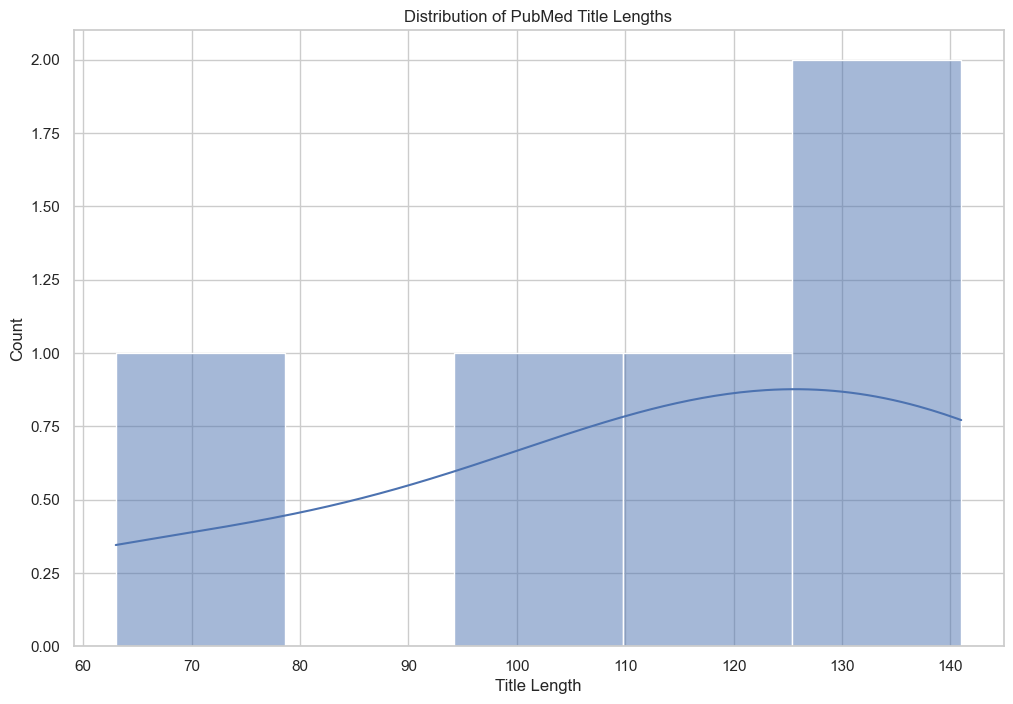

Cell 4: Histogram of Title Lengths displayed.


In [25]:
# Cell 4: Exploration & Visualization on PubMed Data  
pubmed_df['title_length'] = pubmed_df['title'].apply(len)  
plt.figure()  
sns.histplot(pubmed_df['title_length'], bins=5, kde=True)  
plt.title('Distribution of PubMed Title Lengths')  
plt.xlabel('Title Length')  
plt.ylabel('Count')  
plt.show()  
print('Cell 4: Histogram of Title Lengths displayed.')  

In [26]:
# Cell 5: Load Real Patient Experience Data (example)  
# Replace 'patient_experience.csv' with your actual file path.  
if os.path.exists('patient_experience.csv'):  
    patient_df = pd.read_csv('patient_experience.csv')  
    print('Patient experience data loaded.')  
    display(patient_df.head())  
else:  
    print('patient_experience.csv not found. Please provide the file for real patient data.')  

patient_experience.csv not found. Please provide the file for real patient data.


In [27]:
# Cell 6: Load Real Educational Resources Data (example)  
if os.path.exists('educational_resources.csv'):  
    edu_resources_df = pd.read_csv('educational_resources.csv')  
    print('Educational resources data loaded.')  
    display(edu_resources_df.head())  
else:  
    print('educational_resources.csv not found. Please provide the file for real educational data.')  

educational_resources.csv not found. Please provide the file for real educational data.


In [28]:
# Cell 7: Combine Data into LLM Input Data Structure  
def prepare_llm_input(pubmed_df, patient_df=None, edu_resources_df=None):  
    """  
    Combine real data from various sources into a structured dictionary for LLM input.  
    """  
    llm_input = {  
        'pubmed_data': pubmed_df.to_dict(orient='records'),  
        'patient_experience': patient_df.to_dict(orient='records') if patient_df is not None else None,  
        'educational_resources': edu_resources_df.to_dict(orient='records') if edu_resources_df is not None else None  
    }  
    return llm_input  
  
llm_input_data = prepare_llm_input(pubmed_df,   
                                   patient_df if 'patient_df' in globals() else None,   
                                   edu_resources_df if 'edu_resources_df' in globals() else None)  
  
print('Cell 7: LLM input data prepared. Displaying PubMed data portion:')  
display(pd.DataFrame(llm_input_data['pubmed_data']).head())  

Cell 7: LLM input data prepared. Displaying PubMed data portion:


,pubmed_id,title,abstract,title_length
0,40158191,The role of the mTOR pathway in breast cancer ...,Breast cancer remains the most frequently diag...,104
1,40158186,Maternal metabolomics linking prenatal exposur...,Prenatal exposure to air pollution has been as...,141
2,40158170,Intimate partner violence and quality of life ...,Intimate partner violence (IPV) is a prevalent...,117
3,40158153,Attitudes towards the practice of female genit...,"To identify key demographic, socio-economic, a...",139
4,40158146,Axial spondyloarthritis and breastfeeding: a p...,There is sparse literature on the topic of bre...,63
